In [1]:
# To comply with the code style
%load_ext jupyter_black

### Libraries

In [2]:
import numpy as np
import pandas as pd
import torch
import networkx as nx

# Dataset downloader
import opendatasets as od

# Preprocessing
from sklearn.model_selection import train_test_split

# FCA
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

# Models
import neural_lib62 as nl

# Metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
)

# Visualization
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams["figure.facecolor"] = (1, 1, 1, 1)

### Dataset import

In [3]:
od.download("https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset")

Skipping, found downloaded files in ".\stroke-prediction-dataset" (use force=True to force download)


In [4]:
df = pd.read_csv("stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
print(df.shape)
df.head()

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df.describe(include="all")

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110.000000,5110,5110.000000,5110.000000,5110.000000,5110,5110,5110,5110.000000,4909.000000,5110,5110.000000
unique,NaN,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,2994,NaN,NaN,NaN,3353,2925,2596,NaN,NaN,1892,NaN
mean,36517.829354,NaN,43.226614,0.097456,0.054012,NaN,NaN,NaN,106.147677,28.893237,NaN,0.048728
std,21161.721625,NaN,22.612647,0.296607,0.226063,NaN,NaN,NaN,45.283560,7.854067,NaN,0.215320
min,67.000000,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,17741.250000,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.245000,23.500000,NaN,0.000000
50%,36932.000000,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.885000,28.100000,NaN,0.000000
75%,54682.000000,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,33.100000,NaN,0.000000


# Pipeline

## Preprocessing

In [6]:
df.dropna(inplace=True)

In [7]:
df.drop(columns=["id"], inplace=True)

In [8]:
# df = df.iloc[:1000, :]

In [9]:
df.describe(include="all")

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,4909,4909.000000,4909.000000,4909.000000,4909,4909,4909,4909.000000,4909.000000,4909,4909.000000
unique,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,2897,NaN,NaN,NaN,3204,2811,2490,NaN,NaN,1852,NaN
mean,NaN,42.865374,0.091872,0.049501,NaN,NaN,NaN,105.305150,28.893237,NaN,0.042575
std,NaN,22.555115,0.288875,0.216934,NaN,NaN,NaN,44.424341,7.854067,NaN,0.201917
min,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.070000,23.500000,NaN,0.000000
50%,NaN,44.000000,0.000000,0.000000,NaN,NaN,NaN,91.680000,28.100000,NaN,0.000000
75%,NaN,60.000000,0.000000,0.000000,NaN,NaN,NaN,113.570000,33.100000,NaN,0.000000


### Binarizing the data

In [10]:
def inter_ordinal(df, features, boundaries):
    new_df = df.copy()
    new_df.drop(columns=features, inplace=True)
    for i in range(len(features)):
        feature = features[i]
        curr_bound = boundaries[i]
        for boundary in curr_bound:
            new_df[f"{feature}>={boundary}"] = df[feature] >= boundary
            new_df[f"{feature}<={boundary}"] = df[feature] <= boundary

    return new_df

In [11]:
df_bin = inter_ordinal(
    df,
    ["age", "avg_glucose_level", "bmi"],
    [
        [25, 45, 60, 70, 80, 90],
        [70, 100, 120, 135],
        [18, 20, 25, 30, 35, 40],
    ],
)

In [12]:
def nominal(df, features):
    new_df = df.copy()
    for feature in features:
        dummies = pd.get_dummies(df[feature], prefix="", prefix_sep="")
        new_df = pd.concat([new_df, dummies], axis=1)
    new_df.drop(columns=features, inplace=True)
    return new_df

In [13]:
df_bin = nominal(df_bin, ["gender", "work_type", "Residence_type", "smoking_status"])

In [14]:
def dichotomic(df, features):
    new_df = df.copy()
    for feature in features:
        dummies = pd.get_dummies(df[feature], prefix=f"{feature}")
        new_df = pd.concat([new_df, dummies], axis=1)
    new_df.drop(columns=features, inplace=True)
    return new_df

In [15]:
df_bin = dichotomic(df_bin, ["hypertension", "heart_disease", "ever_married"])

In [16]:
df_bin.index

Index([   0,    2,    3,    4,    5,    6,    7,    9,   10,   11,
       ...
       5098, 5100, 5101, 5102, 5103, 5104, 5106, 5107, 5108, 5109],
      dtype='int64', length=4909)

### Spliting the data to train and test

In [17]:
df_bin = df_bin.set_index(np.arange(len(df_bin)).astype(str))

In [18]:
df_bin.index

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '4899', '4900', '4901', '4902', '4903', '4904', '4905', '4906', '4907',
       '4908'],
      dtype='object', length=4909)

In [19]:
y = df_bin["stroke"]
X = df_bin.drop(columns=["stroke"])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [21]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (3927 objects, 52 attributes, 90648 connections)
    |age>=25|age<=25|age>=45|age<=45|age>=60|...|hypertension_1|heart_disease_0|heart_disease_1|ever_married_No|ever_married_Yes|
3404|      X|       |       |      X|       |...|              |              X|               |               |               X|
843 |      X|       |      X|       |       |...|              |              X|               |               |               X|
2581|      X|       |      X|       |       |...|              |              X|               |               |               X|
4020|      X|       |      X|       |      X|...|              |              X|               |               |               X|
2619|      X|       |      X|       |      X|...|              |              X|               |               |               X|
4111|       |      X|       |      X|       |...|              |              X|               |              X|                |
4584|      X|       |      

In [22]:
%%time

L = ConceptLattice.from_context(K_train, algo="Sofia", is_monotone=True)
len(L)

CPU times: total: 22min 21s
Wall time: 23min 28s


80

In [23]:
for c in L:
    print(c.extent, c.intent)

() ('age>=90',)
('2970',) ('age>=90', 'Other')
('3983', '2229', '4227', '557', '3892', '2970', '882', '4594', '2780', '2652', '4581', '902', '213', '3045', '1387', '3797', '2595', '1819', '1693', '2613') ('age>=90', 'Other', 'Never_worked')
('2245', '180', '1545', '220', '73', '2669', '4356', '3946', '4513', '2803', '1793', '2890', '1361', '3603', '3983', '2592', '3144', '1432', '4357', '990', '3588', '912', '44', '413', '4032', '3822', '3878', '2091', '835', '4058', '2988', '2229', '4790', '1216', '4593', '932', '3519', '2144', '2378', '2217', '3277', '1644', '92', '4227', '578', '178', '2801', '437', '3909', '1659', '3616', '3243', '557', '2458', '0', '3959', '1127', '3892', '1880', '204', '1775', '867', '187', '2023', '597', '2171', '1850', '3163', '2398', '4663', '1674', '4192', '407', '86', '2640', '2594', '2970', '2452', '3203', '882', '845', '1689', '834', '340', '4594', '1465', '2780', '1249', '1004', '3320', '42', '3403', '2652', '3711', '1009', '4228', '216', '1239', '275', '

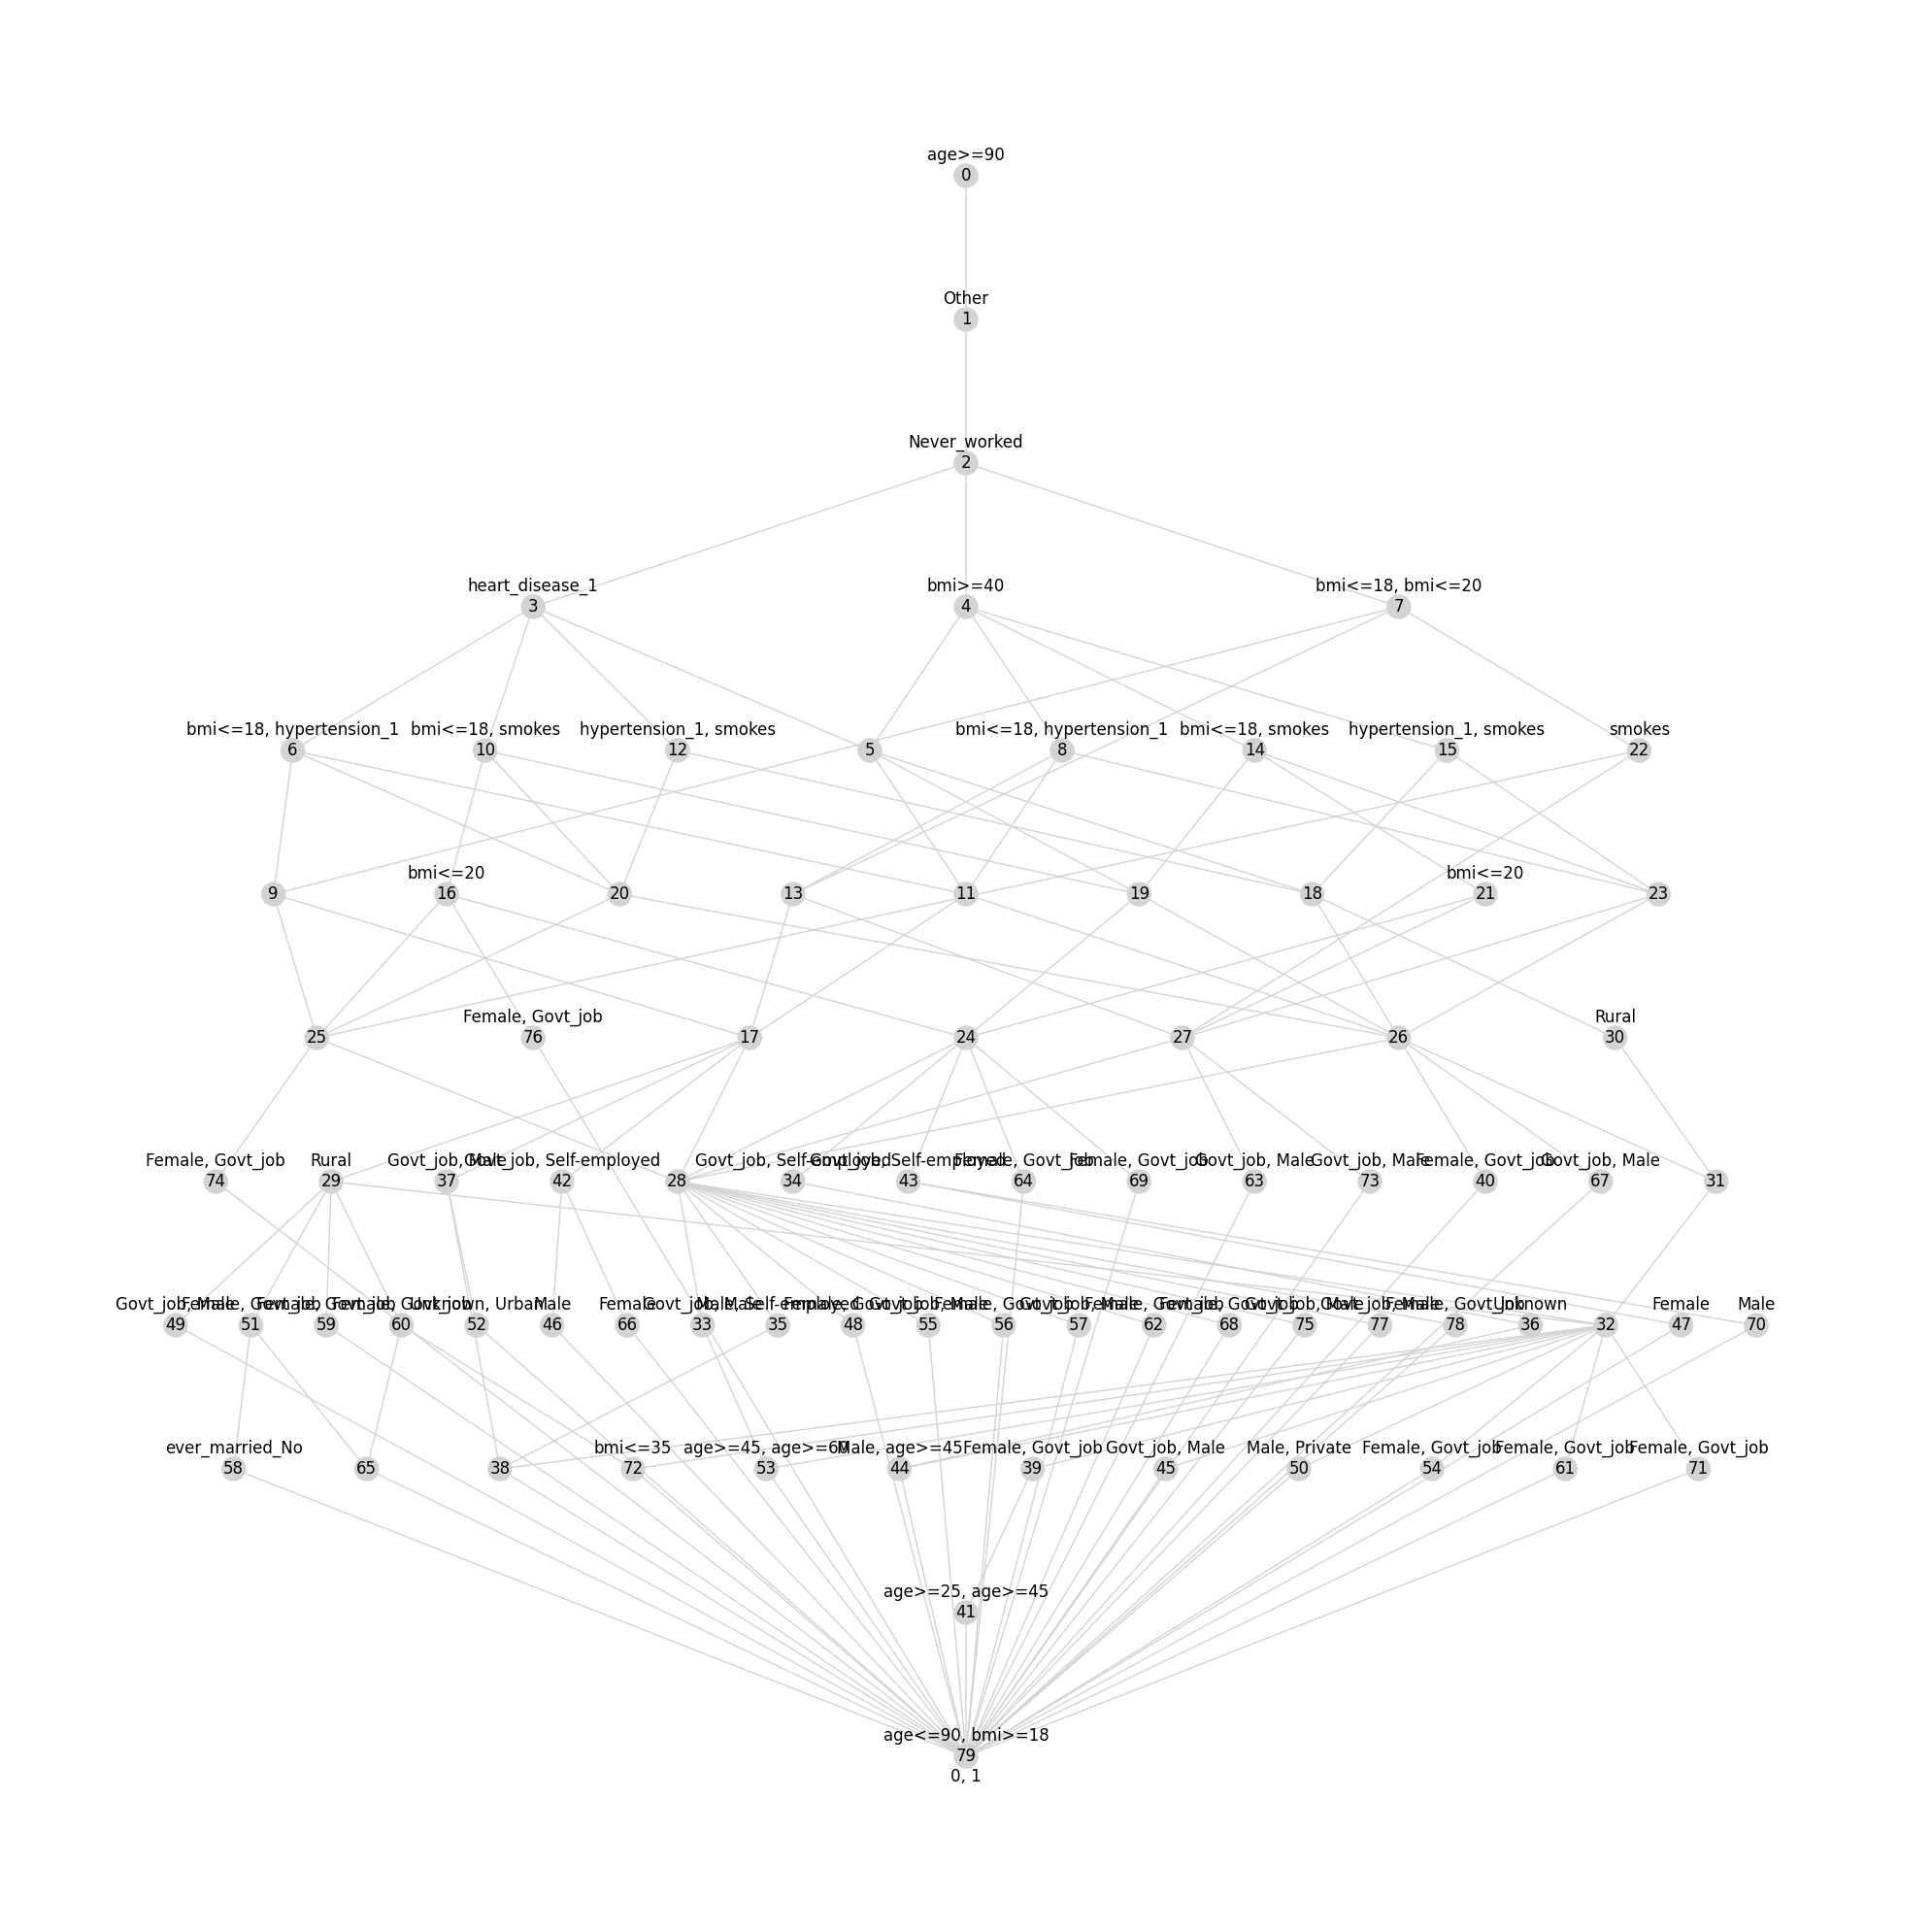

In [24]:
fig, ax = plt.subplots(figsize=(20, 20))
vsl = LineVizNx()
vsl.draw_concept_lattice(
    L,
    ax=ax,
    flg_node_indices=True,
    flg_new_intent_count_prefix=False,
    flg_new_extent_count_prefix=False,
)

plt.tight_layout()
plt.show()

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [25]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures["f1_score"] = f1_score(y_train, y_preds)
    c.measures["accuracy_score"] = accuracy_score(y_train, y_preds)

Select indices of the best concepts from the lattice

In [26]:
n_concepts = 29

In [27]:
# best_concepts = list(np.array([c.measures['f1_score'] for c in L]).argsort()[::-1][:47])
best_concepts = list(L.measures["f1_score"].argsort()[::-1][:n_concepts])

assert (
    len({g_i for c in L[best_concepts] for g_i in c.extent_i}) == K_train.n_objects
), "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [28]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [29]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))
    + "\n\n",
)

Move the nodes in visualization to make it look pretty

In [30]:
set(X_train.columns)

{'Female',
 'Govt_job',
 'Male',
 'Never_worked',
 'Other',
 'Private',
 'Rural',
 'Self-employed',
 'Unknown',
 'Urban',
 'age<=25',
 'age<=45',
 'age<=60',
 'age<=70',
 'age<=80',
 'age<=90',
 'age>=25',
 'age>=45',
 'age>=60',
 'age>=70',
 'age>=80',
 'age>=90',
 'avg_glucose_level<=100',
 'avg_glucose_level<=120',
 'avg_glucose_level<=135',
 'avg_glucose_level<=70',
 'avg_glucose_level>=100',
 'avg_glucose_level>=120',
 'avg_glucose_level>=135',
 'avg_glucose_level>=70',
 'bmi<=18',
 'bmi<=20',
 'bmi<=25',
 'bmi<=30',
 'bmi<=35',
 'bmi<=40',
 'bmi>=18',
 'bmi>=20',
 'bmi>=25',
 'bmi>=30',
 'bmi>=35',
 'bmi>=40',
 'children',
 'ever_married_No',
 'ever_married_Yes',
 'formerly smoked',
 'heart_disease_0',
 'heart_disease_1',
 'hypertension_0',
 'hypertension_1',
 'never smoked',
 'smokes'}

In [31]:
# vis.init_mover_per_poset(cn.poset)
# mvr = vis.mover
# for a, b in [(11, 15), (2, 3), (2,8), (2, 4), (4,5), (24, 26), (22, 26), (23, 25), (22, 24), (6, 7), ]:
#     mvr.swap_nodes(a, b)

# for nodes, vert in [
#     ([19, 18], 0), ([23, 22], 5), ([14, 21,20], 1), ([13, 24, 25], 6), ([26], 7), ([9, 15], 8)
# ]:
#     for a in nodes:
#         mvr.place_node(a, mvr.posx[vert])

In [32]:
descr = {"age<=90", "bmi<=145", "Rural"}

traced = cn.trace_description(descr, include_targets=False)

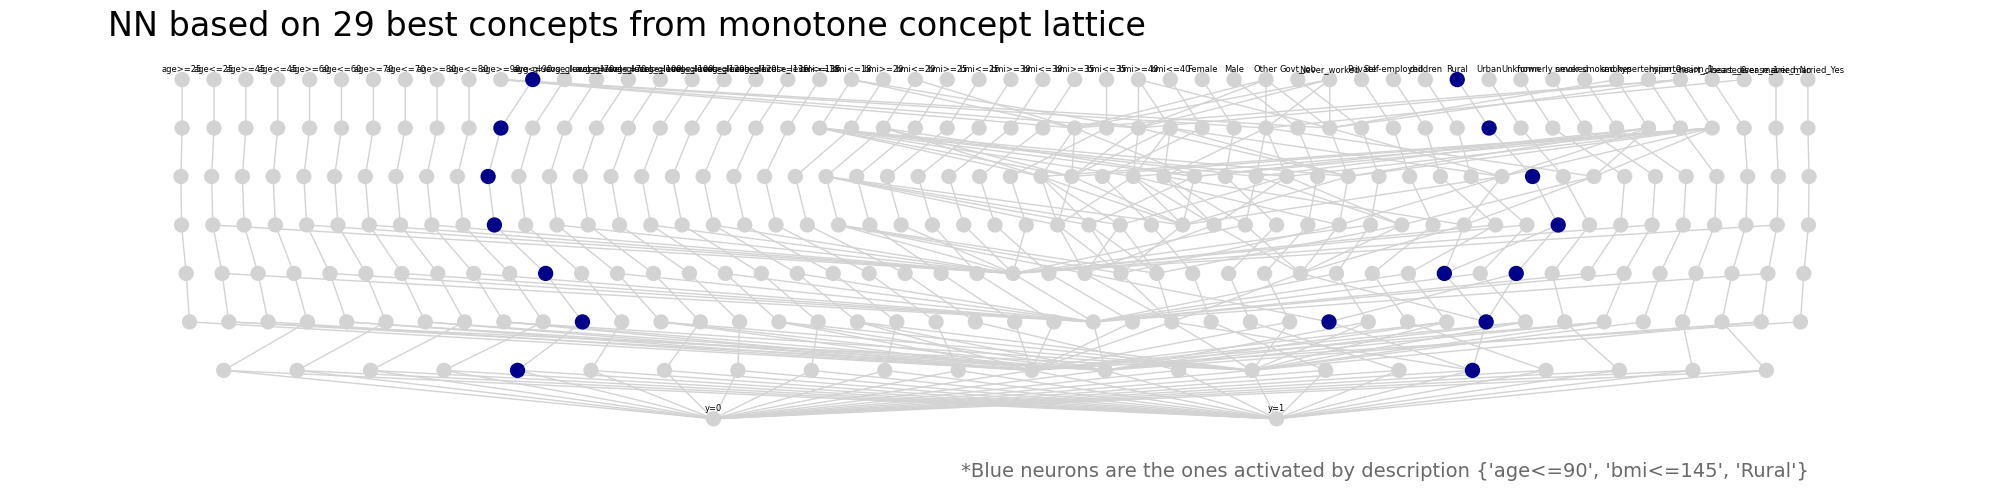

In [33]:
fig, ax = plt.subplots(figsize=(20, 5))

vis.draw_poset(
    cn.poset,
    ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(
        el_i, P, set(cn.attributes), only_new_attrs=True
    )
    + "\n\n",
    node_color=[
        "darkblue" if el_i in traced else "lightgray" for el_i in range(len(cn.poset))
    ],
    node_size=100,
    node_label_font_size=6,
)
plt.title(
    f"NN based on " + str(n_concepts) + " best concepts from monotone concept lattice",
    loc="left",
    x=0.05,
    size=24,
)

plt.text(
    max(vis.mover.posx),
    min(vis.mover.posy) - 0.3,
    f"*Blue neurons are the ones activated by description {descr}",
    fontsize=14,
    ha="right",
    color="dimgray",
)

plt.subplots_adjust()
plt.tight_layout()
plt.savefig("nn_more_concepts.png")
plt.show()

Now fit the network

In [34]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

In [35]:
cn.fit(X_train, y_train, n_epochs=100)

To obtain the prediction

In [36]:
y_pred[0][:10]

NameError: name 'y_pred' is not defined

In [ ]:
y_pred = cn.predict(X_test)
print("Class prediction", y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print("Class prediction with probabilities", y_proba[:10])
print("True class", y_test.values[:10])

In [ ]:
print("Recall score:", recall_score(y_test.values.astype("int"), y_pred[1]))
print("Precision score:", precision_score(y_test.values.astype("int"), y_pred[1]))
print("F1     score:", f1_score(y_test.values.astype("int"), y_pred[1]))
print("Accuracy score:", accuracy_score(y_test.values.astype("int"), y_pred[1]))

Let us look at the fitted weights of edges

In [ ]:
edge_weights = cn.edge_weights_from_network()

fig, ax = plt.subplots(figsize=(15, 5))

vis.draw_poset(
    cn.poset,
    ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(
        el_i, P, set(cn.attributes), only_new_attrs=True
    )
    + "\n\n",
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(
    cn.poset.to_networkx(),
    vis.mover.pos,
    {k: f"{v:.1f}" for k, v in edge_weights.items()},
    label_pos=0.7,
)

plt.title("Neural network with fitted edge weights", size=24, x=0.05, loc="left")
plt.tight_layout()
plt.subplots_adjust()
plt.savefig("fitted_network.png")
plt.show()